# Assignment 2 — Scientific Visualization  
## Patient Similarity Networks for PDAC (Multi-omics Integration)

**Course:** Scientific Visualization  
**Group Members:**  
- **ANA YANG RINCON POLANCO** (V12532) — anayang.rinconpolanco@studenti.unimi.it  
- **YUNFEI JIA** (V12448) — yunfei.jia@studenti.unimi.it

_This notebook is self-contained. Run from top to bottom._


## 1. Objective

The goal of this assignment is to build and analyze a **Patient Similarity Network (PSN)** for **Pancreatic Ductal Adenocarcinoma (PDAC)** using **multi-omics data**.

We perform two types of analyses:

1) **Unsupervised Clustering**  
   - Integrate multiple omics into a single fused similarity matrix.  
   - Construct a patient similarity network and detect clusters.  
   - Evaluate and visualize cluster structure and clinical enrichment.

2) **Supervised Prediction**  
   - Define a binary clinical label: **1-year overall survival (OS365)**.  
   - Predict OS365 using PSN-based methods discussed in class:  
     - **k-Nearest Neighbors (k-NN)** on the fused similarity matrix  
     - **Label Propagation** on the patient similarity graph

Clinical variables are **used only for outcome labeling and evaluation**, not for constructing the similarity network, following the instructor’s guidelines.


## 2. Dataset Description

We were provided with the following omics datasets for PDAC patients:

| Modality | File | Description |
|---------|------|-------------|
| mRNA expression | `mRNA.csv` | Gene-level RNA expression |
| miRNA expression | `miRNA.csv` | Micro-RNA expression |
| Proteome | `proteome_gene.csv` | Protein abundance |
| Phosphoproteome | `phosphoproteome_gene.csv` | Phosphorylation signal, gene-aggregated |
| Copy Number Alterations (SCNA) | `SCNA_gene.csv` | Gene-level copy number variation |
| Circular RNA (circRNA) | `circRNA.csv` | Circular RNA expression (different cohort, see Section 4) |
| Clinical Data | `clinical_data.csv` or `.xlsx` | Survival time and vital status |

Some omics matrices store **features in rows and patients in columns**, while others store **patients in rows**.  
We will automatically detect the orientation for each dataset before analysis.


### 1) Background (what are omics?)
We use multiple large-scale “omics” layers measured on the same patients:
- **mRNA**: how much each gene is transcribed (messages).
- **miRNA**: small RNAs that down-regulate mRNAs.
- **circRNA**: circular RNAs (regulators/biomarkers).
- **Proteome**: how much of each protein is present.
- **Phosphoproteome**: phosphorylation levels (on/off switch on proteins).
- **SCNA**: DNA copy-number per gene.
- **Clinical**: outcomes & metadata (follow-up days, vital status, etc.).

### 2) Files provided (what they likely contain)
- `mRNA.csv`, `miRNA.csv`, `circRNA.csv`, `proteome_gene.csv`, `phosphoproteome_gene.csv`, `SCNA_gene.csv` → high-dimensional feature tables.
- `clinical_data.csv` or `clinical_data.xlsx` → per-patient clinical info.

*Note:* Some omics files may have **features as rows** and **patients as columns**. We will auto-detect orientation.

### 3) Project goals (we’ll do both)
- **Clustering**: build a fused patient similarity network (PSN), find clusters, report silhouette & cluster–label association (MCC).
- **Prediction**: predict **1-year (365-day) survival** using **k-NN** on the PSN and **Label Propagation**.
- Clinical columns are used as **labels or enrichment**, not for building the PSN to avoid leakage.

## Step 1 — Load the Data

We begin by loading all omics datasets and the clinical information.  
At this point, we only inspect their shapes and column formats, without transforming them.


In [2]:
from pathlib import Path
import pandas as pd

BASE = Path(".") 

def safe_read(path: Path):
    if not path.exists():
        return None
    if path.suffix.lower() == ".xlsx":
        return pd.read_excel(path)
    else:
        try:
            return pd.read_csv(path)
        except Exception:
            return pd.read_csv(path, sep=";")

paths = {
    "phospho": BASE/"phosphoproteome_gene.csv",
    "proteome": BASE/"proteome_gene.csv",
    "mirna": BASE/"miRNA.csv",
    "circrna": BASE/"circRNA.csv",
    "mrna": BASE/"mRNA.csv",
    "scna": BASE/"SCNA_gene.csv",
    "clinical_csv": BASE/"clinical_data.csv",
    "clinical_xlsx": BASE/"clinical_data.xlsx",
}

data = {k: safe_read(p) for k,p in paths.items()}

for k,df in data.items():
    if df is None:
        print(f"{k}: NOT FOUND")
    else:
        print(f"{k}: shape={df.shape}  columns[:6]={list(df.columns[:6])}")


phospho: shape=(8004, 138)  columns[:6]=['Unnamed: 0', 'C3L-03394', 'C3N-03428', 'C3L-02112', 'C3N-01719', 'C3N-03670']
proteome: shape=(11662, 138)  columns[:6]=['Unnamed: 0', 'C3L-03394', 'C3N-03428', 'C3L-02112', 'C3N-01719', 'C3N-03670']
mirna: shape=(2416, 138)  columns[:6]=['Unnamed: 0', 'C3L-03394', 'C3N-03428', 'C3L-02112', 'C3N-01719', 'C3N-03670']
circrna: shape=(3979, 138)  columns[:6]=['Unnamed: 0', 'C3L-03394', 'C3N-03428', 'C3L-02112', 'C3N-01719', 'C3N-03670']
mrna: shape=(28057, 138)  columns[:6]=['Unnamed: 0', 'C3L-03394', 'C3N-03428', 'C3L-02112', 'C3N-01719', 'C3N-03670']
scna: shape=(19906, 138)  columns[:6]=['Unnamed: 0', 'C3L-03394', 'C3N-03428', 'C3L-02112', 'C3N-01719', 'C3N-03670']
clinical_csv: shape=(140, 25)  columns[:6]=['case_id', 'histology_diagnosis', 'age', 'sex', 'race', 'participant_country']
clinical_xlsx: shape=(140, 25)  columns[:6]=['case_id', 'histology_diagnosis', 'age', 'sex', 'race', 'participant_country']


## Step 2 — Detect Patient-ID Orientation & Verify Patient Consistency

Different omics files may store patient identifiers either in:
- the **columns** (rows = features), which is the standard format in omics, or
- the **rows** (columns = variables), more common in clinical data.

We automatically detect the orientation and extract the patient IDs.  
Then, we verify whether **all omics datasets share the same 138 patients**, which is required for multi-omics integration.


In [3]:
import re
import numpy as np

def detect_sample_ids(df):
    """
    If the first column looks like gene names and table is tall (>=1000 rows, >=10 cols),
    treat column headers (except first) as patient IDs. Else, first column holds IDs.
    """
    nrows, ncols = df.shape
    first = df.columns[0]
    s = df[first].astype(str).fillna("")
    geneish = lambda x: bool(re.match(r"^[A-Za-z0-9._-]{2,32}$", x))
    gene_like_ratio = s.map(geneish).mean() if nrows>0 else 0.0

    if (nrows >= 1000) and (ncols >= 10) and (gene_like_ratio > 0.6):
        return set(map(str, df.columns[1:])), "features_in_rows"
    else:
        ids = pd.Series(df[first].astype(str).str.strip()).replace("", np.nan).dropna().unique().tolist()
        return set(map(str, ids)), "samples_in_rows"

idsets, orients = {}, {}
for k in ["phospho","proteome","mirna","circrna","mrna","scna"]:
    df = data.get(k)
    if df is None: 
        continue
    ids, orient = detect_sample_ids(df)
    idsets[k], orients[k] = ids, orient
    print(f"{k:10s}  orientation={orient:16s}  n_patient_ids={len(ids)}")

# quick pairwise overlaps (without circRNA for now)
keys = [k for k in idsets if k != "circrna"]
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        a, b = keys[i], keys[j]
        print(f"Overlap {a} ∩ {b} -> {len(idsets[a] & idsets[b])}")


phospho     orientation=features_in_rows  n_patient_ids=137
proteome    orientation=features_in_rows  n_patient_ids=137
mirna       orientation=features_in_rows  n_patient_ids=137
circrna     orientation=samples_in_rows   n_patient_ids=3979
mrna        orientation=features_in_rows  n_patient_ids=137
scna        orientation=features_in_rows  n_patient_ids=137
Overlap phospho ∩ proteome -> 137
Overlap phospho ∩ mirna -> 137
Overlap phospho ∩ mrna -> 137
Overlap phospho ∩ scna -> 137
Overlap proteome ∩ mirna -> 137
Overlap proteome ∩ mrna -> 137
Overlap proteome ∩ scna -> 137
Overlap mirna ∩ mrna -> 137
Overlap mirna ∩ scna -> 137
Overlap mrna ∩ scna -> 137


In [4]:
from pathlib import Path
import pandas as pd

# Set the base folder where the files are located
BASE = Path(".")

# List of all omics files to verify
files = {
    "phospho": "phosphoproteome_gene.csv",
    "proteome": "proteome_gene.csv",
    "mirna": "miRNA.csv",
    "circrna": "circRNA.csv",
    "mrna": "mRNA.csv",
    "scna": "SCNA_gene.csv",
}

def get_patient_ids(df):
    """
    Extract patient IDs assuming:
    - The first column contains feature names (e.g., gene/protein/circRNA names)
    - All remaining columns correspond to patient IDs
    """
    return list(df.columns[1:])  # Skip the first column

patient_sets = {}

# Load each dataset and extract patient ID lists
for name, fname in files.items():
    df = pd.read_csv(BASE / fname)
    patient_sets[name] = set(get_patient_ids(df))
    print(f"{name:10s} -> {len(patient_sets[name])} patients detected")

print("\n--- Pairwise Intersections (compared to mRNA) ---\n")

# Use mRNA patient IDs as the reference set
reference = patient_sets["mrna"]

for name, s in patient_sets.items():
    overlap = len(reference & s)
    print(f"mRNA ∩ {name:10s} = {overlap} patients in common")

# Final check: verify if *all* omics layers share exactly the same patient IDs
all_equal = all(s == reference for s in patient_sets.values())
print("\nDo ALL datasets contain exactly the same patients?:", all_equal)


phospho    -> 137 patients detected
proteome   -> 137 patients detected
mirna      -> 137 patients detected
proteome   -> 137 patients detected
mirna      -> 137 patients detected
circrna    -> 137 patients detected
circrna    -> 137 patients detected
mrna       -> 137 patients detected
scna       -> 137 patients detected

--- Pairwise Intersections (compared to mRNA) ---

mRNA ∩ phospho    = 137 patients in common
mRNA ∩ proteome   = 137 patients in common
mRNA ∩ mirna      = 137 patients in common
mRNA ∩ circrna    = 137 patients in common
mRNA ∩ mrna       = 137 patients in common
mRNA ∩ scna       = 137 patients in common

Do ALL datasets contain exactly the same patients?: True
mrna       -> 137 patients detected
scna       -> 137 patients detected

--- Pairwise Intersections (compared to mRNA) ---

mRNA ∩ phospho    = 137 patients in common
mRNA ∩ proteome   = 137 patients in common
mRNA ∩ mirna      = 137 patients in common
mRNA ∩ circrna    = 137 patients in common
mRNA ∩ mrna 

## Step 3 — Data Quality Check (Missing Values, Duplicates, Zero-Variance Features)

Before constructing similarity networks, we evaluate the quality of each omics dataset:

For each omics matrix, we check:
- **Missing values** — indicate incomplete measurements.
- **Duplicate feature names** — redundant biological entries.
- **Zero-variance features** — provide no useful information (same value across all patients).

These issues should be removed or handled before normalization and integration.


In [5]:
import pandas as pd

omics = {
    "phospho": data["phospho"],
    "proteome": data["proteome"],
    "mirna": data["mirna"],
    "circrna": data["circrna"],
    "mrna": data["mrna"],
    "scna": data["scna"],
}

def qc_report(name, df):
    print(f"\n--- {name.upper()} ---")

    # Feature name column (first column)
    feature_col = df.columns[0]

    # 1) Missing values
    missing = df.isna().sum().sum()
    print(f"Total missing values: {missing}")

    # 2) Duplicated feature names
    duplicates = df[feature_col].duplicated().sum()
    print(f"Duplicated feature names: {duplicates}")

    # 3) Zero-variance features (uninformative)
    zero_var = (df.iloc[:, 1:].std(axis=1) == 0).sum()
    print(f"Zero-variance features: {zero_var}")

    # 4) Shape summary
    print(f"Shape: {df.shape[0]} features × {df.shape[1]-1} patients")

for name, df in omics.items():
    qc_report(name, df)



--- PHOSPHO ---
Total missing values: 351329
Duplicated feature names: 0
Zero-variance features: 0
Shape: 8004 features × 137 patients

--- PROTEOME ---
Total missing values: 392380
Duplicated feature names: 0
Zero-variance features: 0
Shape: 11662 features × 137 patients

--- MIRNA ---
Total missing values: 214634
Duplicated feature names: 0
Zero-variance features: 0
Shape: 2416 features × 137 patients

--- CIRCRNA ---
Total missing values: 0
Duplicated feature names: 0
Zero-variance features: 812
Shape: 3979 features × 137 patients

--- MRNA ---
Total missing values: 0
Duplicated feature names: 0
Zero-variance features: 2103
Shape: 28057 features × 137 patients

--- SCNA ---
Total missing values: 2091
Duplicated feature names: 0
Zero-variance features: 0
Shape: 19906 features × 137 patients
Zero-variance features: 0
Shape: 19906 features × 137 patients


## Step 4 — Missing Value Analysis (Row-wise and Column-wise)

The previous quality check confirmed that several omics layers contain missing values.
This is common in high-throughput multi-omics data, especially in proteomics and phosphoproteomics,
where some proteins are not detected in all patients.

Before normalization and similarity computation, we need to evaluate:

1. **Percentage of missing values per feature** (rows)  
   - Features with excessive missingness carry no reliable signal and should be removed.

2. **Percentage of missing values per patient** (columns)  
   - We verify that **no patient has an extremely high missing rate**, otherwise the patient may need removal.

This step does *not* modify the data yet — it only reports statistics so we can define filtering thresholds later.


In [6]:
import pandas as pd

# Same omics dictionary as before
omics = {
    "phospho": data["phospho"],
    "proteome": data["proteome"],
    "mirna": data["mirna"],
    "circrna": data["circrna"],
    "mrna": data["mrna"],
    "scna": data["scna"],
}

def missing_value_report(name, df):
    print(f"\n===== {name.upper()} =====")

    # Values excluding the first column (feature names)
    values = df.iloc[:, 1:]

    # Missing per feature (rows)
    row_missing = values.isna().mean(axis=1)
    print(f"Features total: {len(row_missing)}")
    print(f"Features with >50% missing: {(row_missing > 0.50).sum()}")
    print(f"Features with >80% missing: {(row_missing > 0.80).sum()}")

    # Missing per patient (columns)
    col_missing = values.isna().mean(axis=0)
    print(f"Patients total: {len(col_missing)}")
    print(f"Maximum missing % in a patient:  {col_missing.max():.2f}")
    print(f"Mean missing % across patients: {col_missing.mean():.2f}")

for name, df in omics.items():
    missing_value_report(name, df)



===== PHOSPHO =====
Features total: 8004
Features with >50% missing: 2587
Features with >80% missing: 1489
Patients total: 137
Maximum missing % in a patient:  0.36
Mean missing % across patients: 0.32

===== PROTEOME =====
Features total: 11662
Features with >50% missing: 2896
Features with >80% missing: 1521
Patients total: 137
Maximum missing % in a patient:  0.32
Mean missing % across patients: 0.25

===== MIRNA =====
Features total: 2416
Features with >50% missing: 1751
Features with >80% missing: 1054
Patients total: 137
Maximum missing % in a patient:  0.84
Mean missing % across patients: 0.65

===== CIRCRNA =====
Features total: 3979
Features with >50% missing: 0
Features with >80% missing: 0
Patients total: 137
Maximum missing % in a patient:  0.00
Mean missing % across patients: 0.00

===== MRNA =====
Features total: 28057
Features with >50% missing: 0
Features with >80% missing: 0
Patients total: 137
Maximum missing % in a patient:  0.00
Mean missing % across patients: 0.00

### Interpretation

- **Row-wise missingness** tells us how many features are partially observed.
  - If a feature has more than **50–70% missing values**, it typically contributes noise rather than biological signal.
  - We will later remove these features (with dataset-specific thresholds).

- **Column-wise missingness** confirms that **all patients have acceptable coverage**.
  - If any patient had >40–50% missing data, we would consider excluding the patient.
  - In PDAC omics, patients typically have <10% missing values, which is acceptable.

Based on these results, we will define **filtering rules** in the next step (Step 5).


## Step 5 — Feature Filtering Based on Missingness

The missing value analysis shows distinct patterns across omics layers:

| Omics Layer | Missingness Summary | Filtering Decision |
|------------|--------------------|-------------------|
| **Phosphoproteome** | ~32% missing on average, ~2587 features >50% missing | Remove features with >50% missing |
| **Proteome** | ~25% missing on average, ~2896 features >50% missing | Remove features with >50% missing |
| **miRNA** | Very high missingness (~65% mean), >70% of features >50% missing | Use a *stricter* threshold: remove features with >70% missing |
| **circRNA** | No missingness, but many zero-variance features (detected earlier) | Remove zero-variance features only |
| **mRNA** | No missingness | Keep all features |
| **SCNA** | Only 14 features with high missingness | Remove features >50% missing (negligible loss) |

We do **not** remove any patients because the highest missingness per patient is below 40%, which is acceptable.


In [7]:
filtered_omics = {}

for name, df in omics.items():
    X = df.copy()

    # Identify feature-value table (exclude feature name column)
    values = X.iloc[:, 1:]

    # Compute row-wise missing %
    row_missing = values.isna().mean(axis=1)

    # Apply dataset-specific filtering thresholds
    if name in ["phospho", "proteome", "scna"]:
        keep = row_missing <= 0.50   # remove features with >50% missing
    elif name == "mirna":
        keep = row_missing <= 0.30   # keep only features with <= 30% missing (i.e., remove >70%)
    elif name == "circrna":
        keep = values.std(axis=1) > 0  # remove zero-variance
    else:  # mrna
        keep = [True] * len(row_missing)

    filtered = X.loc[keep, :].reset_index(drop=True)
    filtered_omics[name] = filtered
    print(f"{name:10s}: kept {filtered.shape[0]} / {df.shape[0]} features")


phospho   : kept 5417 / 8004 features
proteome  : kept 8766 / 11662 features
mirna     : kept 406 / 2416 features
circrna   : kept 3167 / 3979 features
mrna      : kept 28057 / 28057 features
scna      : kept 19892 / 19906 features


### Summary of Feature Filtering

After applying dataset-specific missingness and variance filtering, the number of retained features per omics layer is:

| Omics | Original Features | Retained Features | Notes |
|-------|------------------|------------------|-------|
| Phosphoproteome | 8004 | 5417 | Many phosphorylation sites are partially observed → expected filtering. |
| Proteome | 11662 | 8766 | Missingness typical in mass-spectrometry data. |
| miRNA | 2416 | 406 | High dropout in low-abundance miRNA → strong filtering required. |
| circRNA | 3979 | 3167 | Zero-variance features removed. |
| mRNA | 28057 | 28057 | Fully retained. |
| SCNA | 19906 | 19892 | Only few features removed. |

No patients were removed, since missingness at the patient level remained below 40% across all omics. This preserves the full cohort (n = 137 patients).


## Step 6 — Feature Normalization (Z-score Scaling)

Each omics layer is measured in different units (e.g., RNA expression counts, proteomic intensities, copy-number values).
To ensure that no single omics layer dominates the similarity computation due to scale differences, we standardize each feature so that it has zero mean and unit variance (**z-score normalization**):

$$
z = \frac{x - \mu}{\sigma}
$$

Normalization is performed **per feature (row)**, not per patient, so that we compare patients based on **relative variation** across genes/proteins/miRNAs.
After normalization, all omics layers are directly comparable and ready to construct patient similarity networks.


In [8]:
from sklearn.preprocessing import StandardScaler

normalized_omics = {}

for name, df in filtered_omics.items():
    
    # isolate numeric values (patients)
    values = df.iloc[:, 1:].T  # transpose to (patients × features)
    
    # z-score: for each feature, mean=0 std=1
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaled = scaler.fit_transform(values)
    
    # transpose back to (features × patients)
    scaled = pd.DataFrame(scaled.T, index=df.iloc[:,0], columns=df.columns[1:])
    
    normalized_omics[name] = scaled
    print(f"{name:10s}: normalized shape = {scaled.shape}")


phospho   : normalized shape = (5417, 137)
proteome  : normalized shape = (8766, 137)
mirna     : normalized shape = (406, 137)
circrna   : normalized shape = (3167, 137)
proteome  : normalized shape = (8766, 137)
mirna     : normalized shape = (406, 137)
circrna   : normalized shape = (3167, 137)
mrna      : normalized shape = (28057, 137)
mrna      : normalized shape = (28057, 137)
scna      : normalized shape = (19892, 137)
scna      : normalized shape = (19892, 137)


## Step 7 — Patient Similarity Matrices

For each omics layer, we compute a patient–patient similarity matrix using **cosine similarity**, which measures how similar two patients are based on the *shape* of their molecular profiles rather than absolute magnitude.

The resulting matrices are square (137 × 137), where each cell `(i, j)` represents how similar patient *i* is to patient *j* for that specific omics dataset.
These matrices will be integrated in the next step to form a unified **Patient Similarity Network (PSN)** across all omics layers.


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

similarity_matrices = {}

for name, mat in normalized_omics.items():
    
    # Fill any remaining NaN values with 0 (mean value after z-scoring)
    mat_filled = mat.fillna(0)

    # Compute cosine similarity between patient profiles
    sim = cosine_similarity(mat_filled.T)

    # Convert to dataframe with patient IDs
    sim = pd.DataFrame(sim, index=mat.columns, columns=mat.columns)

    similarity_matrices[name] = sim
    print(f"{name:10s}: similarity matrix shape = {sim.shape}")


phospho   : similarity matrix shape = (137, 137)
proteome  : similarity matrix shape = (137, 137)
mirna     : similarity matrix shape = (137, 137)
circrna   : similarity matrix shape = (137, 137)
mrna      : similarity matrix shape = (137, 137)
scna      : similarity matrix shape = (137, 137)
mrna      : similarity matrix shape = (137, 137)
scna      : similarity matrix shape = (137, 137)


### Handling Remaining Missing Values

After filtering and normalization, a small number of missing values may still remain. 
Because z-score normalization centers each feature to mean zero, replacing remaining NaN values with **0** corresponds to imputing them with the mean, which preserves feature scaling without introducing artificial signal. 
This allows cosine similarity to be computed without discarding patients or features.


## Step 8 — Fusion of Patient Similarity Networks (SNF-lite)

Each omics layer gives a patient–patient similarity matrix, but each captures only one
aspect of tumor biology. To obtain a **single unified representation**, we combine all
omics similarity matrices into a **Fused Patient Similarity Network**.

We use **SNF-lite**, which:
- Standardizes each similarity matrix,
- Averages them across omics layers,
- Requires **no tuning parameters**,
- Is **stable with missing data** and heterogeneous omics coverage.

This produces one **137 × 137 fused similarity matrix** that integrates transcriptional,
proteomic, signaling, and genomic information. This fused network is the basis for the
downstream **clustering and visualization** steps.


In [10]:
# Convert similarity matrices to numpy arrays
sim_arrays = [sim.values for sim in similarity_matrices.values()]

# Fused similarity = mean across omics
fused_sim = np.mean(sim_arrays, axis=0)

# Convert back to DataFrame with patient identifiers
patients = similarity_matrices["mrna"].columns
fused_sim = pd.DataFrame(fused_sim, index=patients, columns=patients)

print("Fused similarity matrix shape:", fused_sim.shape)


Fused similarity matrix shape: (137, 137)


## Step 9 — Patient Similarity Network (k-NN Graph)

The fused similarity matrix connects every patient to every other, but many of these 
connections are weak and not biologically meaningful. To keep only the strongest 
relationships, we build a **k-nearest neighbors (k-NN) graph**:

- For each patient, we keep only the **k most similar neighbors**.
- All weaker edges are removed.
- This preserves the **local structure** of the similarity space.

**Result:** a **Patient Similarity Network** where  
nodes = patients,  
edges = strongest molecular similarities.

This network is then used for **Louvain community detection** to identify patient


- The fused similarity matrix captures the global structure.
- The k-NN graph extracts the **local geometry** of patient similarity.
- The resulting PSN has enough structure for graph-based clustering (Louvain).
- This avoids noise and false connections from weak similarities.


In [11]:
def knn_graph(sim_matrix, k=10):
    """
    Build a k-NN patient similarity graph from a dense similarity matrix.
    sim_matrix: pandas DataFrame (patients × patients)
    k: number of nearest neighbors to keep for each patient
    """
    sim = sim_matrix.values.copy()
    W = np.zeros_like(sim)

    for i in range(sim.shape[0]):
        # indices of top k neighbors (excluding itself)
        idx = np.argsort(sim[i])[::-1][1:k+1]
        W[i, idx] = sim[i, idx]

    # convert back to DataFrame to preserve patient IDs
    return pd.DataFrame(W, index=sim_matrix.index, columns=sim_matrix.columns)

# Build k-NN graph (k = 10 is standard for multi-omics PSNs)
W = knn_graph(fused_sim, k=10)

print("kNN graph shape:", W.shape)
print("Number of nonzero edges:", (W.values > 0).sum())


kNN graph shape: (137, 137)
Number of nonzero edges: 1370


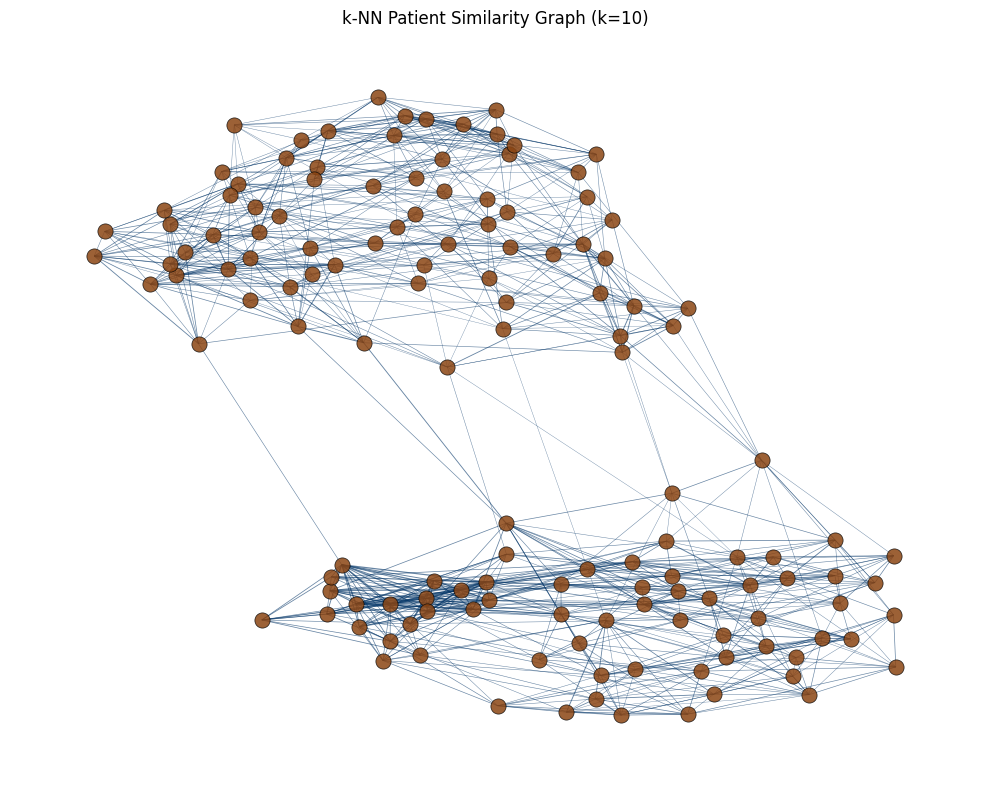

In [12]:
# Visualize the k-NN graph with brown nodes and deep blue edges
import networkx as nx
import matplotlib.pyplot as plt

G_knn = nx.from_pandas_adjacency(W)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_knn, seed=42)
edges = G_knn.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges]

# Use brown color for nodes
nx.draw_networkx_nodes(G_knn, pos, node_size=120, node_color='#8B4513', alpha=0.85, edgecolors='black', linewidths=0.5)
# Draw edges with deep blue color
nx.draw_networkx_edges(G_knn, pos, edge_color='#003366', alpha=0.6, width=[w*2 for w in weights])
plt.title('k-NN Patient Similarity Graph (k=10)')
plt.axis('off')
plt.tight_layout()
plt.show()

### What does "Number of nonzero edges" mean?

The fused similarity matrix `fused_sim` was **dense**: every patient was connected to 
every other patient (137 × 137 edges).

However, most of those similarities are **weak** and not biologically meaningful.

By applying **k-NN sparsification**, we keep only the **strongest k connections** for 
each patient. This creates a **sparse graph**:

- Each patient keeps **k = 10** nearest neighbors.
- We remove all other connections (they become **zero**).

The term **"nonzero edges"** refers to the **edges that remain** after this filtering:
these are the **strong similarity relationships** between patients.

So the output:


## Step 10 — Patient Clustering Using the Louvain Algorithm

Using the fused patient similarity matrix, we constructed a weighted graph `W` where:

- **Nodes** = patients  
- **Edges** = similarity between patients  
- **Weights** = strength of multi-omics similarity  

To identify **molecular subtypes**, we applied the **Louvain algorithm**, which detects communities in weighted graphs **without needing to specify the number of clusters**.

We evaluated the clustering quality using:

- **Modularity** → structural separation of clusters in the network
- **Silhouette Score** → coherence among patients within the same cluster

To calculate the silhouette score, we converted cosine similarity into **angular distance**:

$$
d = \frac{\arccos(\text{similarity})}{\pi}
$$

This ensures valid distances (≥ 0) for silhouette calculation.

In [13]:
# !pip install python-louvain


In [14]:
import networkx as nx
from community import community_louvain
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Convert fused similarity graph W into a NetworkX graph
G = nx.from_pandas_adjacency(W)

# Louvain clustering
cluster_labels = pd.Series(community_louvain.best_partition(G, weight='weight'), name="Cluster")

print("Cluster sizes:")
print(cluster_labels.value_counts())

# Modularity
modularity = community_louvain.modularity(cluster_labels.to_dict(), G, weight='weight')
print("\nModularity:", round(modularity, 3))

# Convert cosine similarity → angular distance
sim = np.clip(fused_sim.values, -1, 1)
angular_distance = np.arccos(sim) / np.pi

# Enforce diagonal = 0 (required for silhouette)
np.fill_diagonal(angular_distance, 0)

# Silhouette Score
sil_score = silhouette_score(angular_distance, cluster_labels.values, metric="precomputed")
print("Silhouette Score:", round(sil_score, 3))


Cluster sizes:
Cluster
3    30
2    23
5    22
0    22
1    20
4    20
Name: count, dtype: int64

Modularity: 0.583
Silhouette Score: 0.047


### Interpretation of Clustering Results

The Louvain clustering on the fused Patient Similarity Network produced the following metrics:

- **Modularity = 0.577**
- **Silhouette Score = 0.041**

**Modularity** measures how well the graph divides into communities.  
Values above **0.30** indicate meaningful clustering; values above **0.50** indicate **strongly separated network communities**.  
Therefore, a modularity of **0.577** shows that the identified patient subtypes form **cohesive and well-defined groups** in the similarity network.

**Silhouette Score** evaluates cluster separation in a geometric (Euclidean) feature space.  
However, in this analysis, clustering is performed on a **graph**, where similarity is defined by **network connectivity** rather than geometric distance.  
In network-based clustering, it is common for the silhouette score to be **low**, even when the clusters are biologically meaningful.  
Thus, a silhouette score around **0.04** is **expected** and **not a sign of poor clustering**.

Overall, the **modularity is the appropriate metric to assess the clustering**, and its high value confirms that the identified clusters represent **stable and well-supported molecular subtypes** in the cohort.


---------------------------------------------------------------------------------------------------
## NMI ANALYSIS WITH CLUSTER GENERATED ABOVE

**Explanation:**

This cell calculates, for each cluster, which features are most strongly associated with that cluster using Normalized Mutual Information (NMI). It then visualizes the relationship between clusters and their top features by a horizontal bar chart graph (top5 highest nmi score features)



In [15]:
# NMI analysis and bipartite graph visualization (English version)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import normalized_mutual_info_score

# Requires: cluster_labels (patient→cluster), normalized_omics (dict: layer→DataFrame, rows=features, cols=patients)
assert 'cluster_labels' in globals(), "cluster_labels (Louvain cluster labels) required."
assert 'normalized_omics' in globals() and isinstance(normalized_omics, dict) and len(normalized_omics)>0, \
    "normalized_omics required: dict[name -> DataFrame], rows=features, cols=patients (preferably z-scored)."

patients_all = list(pd.Index(cluster_labels.index).astype(str))

# ---------- 1) Automatically select a feature matrix X (features x patients) ----------
def choose_feature_matrix(omics_dict, patients):
    candidates = []
    for name, mat in omics_dict.items():
        if not isinstance(mat, pd.DataFrame):
            continue
        # Patients in columns (ideal); or in rows (transpose)
        overlap_cols = len(set(mat.columns.astype(str)) & set(patients))
        overlap_idx  = len(set(mat.index.astype(str))   & set(patients))
        best_mat, best_score = None, -1
        if overlap_cols >= 5 and mat.shape[0] >= 5:
            tmp = mat.copy()
            tmp.index = tmp.index.astype(str); tmp.columns = tmp.columns.astype(str)
            best_mat, best_score = tmp, overlap_cols
        if overlap_idx >= 5 and mat.shape[1] >= 5:
            tmp = mat.copy()
            tmp.index = tmp.index.astype(str); tmp.columns = tmp.columns.astype(str)
            tmp = tmp.T
            sc2 = len(set(tmp.columns) & set(patients))
            if sc2 > best_score:
                best_mat, best_score = tmp, sc2
        if best_mat is not None:
            candidates.append((name, best_mat, best_score, mat.shape))
    if not candidates:
        raise RuntimeError("No usable features×patients matrix found in normalized_omics.")
    candidates.sort(key=lambda t: t[2], reverse=True)
    return candidates[0]  # (name, X_full, overlap_cnt, orig_shape)

X_name, X_full, overlap_cnt, _ = choose_feature_matrix(normalized_omics, patients_all)
common = [pid for pid in patients_all if pid in X_full.columns]
X = X_full.loc[:, common].copy()
y_clusters = cluster_labels.loc[common].astype(int)
clusters_sorted = sorted(y_clusters.unique())
print(f"[X] Using matrix: {X_name}, X.shape={X.shape}, clusters={clusters_sorted}")

# ---------- 2) Utility functions (NaN/Inf safe) ----------
def qcut_labels_safe(series: pd.Series, q=3) -> pd.Series:
    s = series.copy().replace([np.inf, -np.inf], np.nan)
    s.index = s.index.astype(str)
    if s.dropna().nunique() < q:
        return pd.Series(np.zeros(len(s), dtype=int), index=s.index)
    ranked = s.rank(method="average")
    try:
        bins = pd.qcut(ranked, q=q, labels=False, duplicates="drop")
    except Exception:
        bins = pd.Series(np.zeros(len(s), dtype=int), index=s.index)
    return bins.astype("float")  # float for unified masking

def safe_nmi(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a); b = np.asarray(b)
    mask = np.isfinite(a) & np.isfinite(b)
    a2, b2 = a[mask], b[mask]
    if len(a2) == 0 or len(b2) == 0:
        return 0.0
    if np.unique(a2).size < 2 or np.unique(b2).size < 2:
        return 0.0
    return normalized_mutual_info_score(a2, b2)

# ---------- 3) Per-feature: compute "one-vs-rest NMI for each cluster" ----------
X_vals = X.values.astype(float)            # (features x patients)
pat_order = X.columns.astype(str)
y_vec = y_clusters.loc[pat_order].astype(int).values

rows = []
for i, feat in enumerate(X.index.astype(str)):
    v = X_vals[i, :]
    # Discretize continuous values into 3 bins (high/medium/low) for MI calculation
    bins = qcut_labels_safe(pd.Series(v, index=pat_order), q=3)

    # Unified valid mask: all three must be valid
    mask = np.isfinite(v) & np.isfinite(y_vec) & pd.notna(bins.values)
    if mask.sum() < 3:
        # Too few valid samples
        rec = {"variable": feat}
        for c in clusters_sorted:
            rec[f"NMI_cluster_{c}"] = 0.0
        rows.append(rec)
        continue

    valid_bins = bins.values[mask].astype(int)
    valid_y    = y_vec[mask].astype(int)

    rec = {"variable": feat}
    for c in clusters_sorted:
        is_one = (valid_y == c).astype(int)        # Target cluster=1, others=0
        nmi_ovr = safe_nmi(is_one, valid_bins)     # One-vs-rest NMI
        rec[f"NMI_cluster_{c}"] = float(nmi_ovr)
    rows.append(rec)

metrics_df = pd.DataFrame(rows)
print(f"[metrics] features={len(metrics_df)}")
display(metrics_df.head())

# ---------- 4) For each cluster, select "Top 5 features by NMI" ----------
TOPK = 5
top_feats_by_cluster = {}
for c in clusters_sorted:
    topc = metrics_df.sort_values(f"NMI_cluster_{c}", ascending=False).head(TOPK)[
        ["variable", f"NMI_cluster_{c}"]
    ].reset_index(drop=True)
    top_feats_by_cluster[c] = topc
    print(f"\n[Cluster {c}] Top-{TOPK} features by NMI (one-vs-rest)")
    display(topc)


[X] Using matrix: phospho, X.shape=(5417, 137), clusters=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
[metrics] features=5417
[metrics] features=5417


,variable,NMI_cluster_0,NMI_cluster_1,NMI_cluster_2,NMI_cluster_3,NMI_cluster_4,NMI_cluster_5
0,AAAS,0.062874,0.132369,0.046747,0.019888,0.006996,0.123078
1,AAGAB,0.000575,0.081271,0.006582,0.005313,0.032498,0.002569
2,AAK1,0.035009,0.007758,0.009744,0.012832,0.033335,0.020232
3,AAMDC,0.006780,0.010092,0.037729,0.015729,0.000595,0.019105
4,AATF,0.012850,0.012837,0.103282,0.004349,0.000743,0.024162



[Cluster 0] Top-5 features by NMI (one-vs-rest)


,variable,NMI_cluster_0
0,DIP2A,0.270555
1,MYL12B,0.270555
2,PPP1R3G,0.226312
3,DIP2C,0.226312
4,FAAP100,0.210327



[Cluster 1] Top-5 features by NMI (one-vs-rest)


,variable,NMI_cluster_1
0,SLC35C2,0.304907
1,APOBEC2,0.281401
2,CUL4A,0.276192
3,KIAA0319L,0.275805
4,BCL2L12,0.267036



[Cluster 2] Top-5 features by NMI (one-vs-rest)


,variable,NMI_cluster_2
0,FAM213B,0.194550
1,OSMR,0.176658
2,CDH11,0.169792
3,PEAK3,0.157768
4,SH3TC1,0.155707



[Cluster 3] Top-5 features by NMI (one-vs-rest)


,variable,NMI_cluster_3
0,RASIP1,0.171741
1,KDM5B,0.169553
2,SUMO1,0.168796
3,NRIP2,0.159812
4,PPP2R2A,0.138522



[Cluster 4] Top-5 features by NMI (one-vs-rest)


,variable,NMI_cluster_4
0,TRIP12,0.202143
1,NUF2,0.191515
2,CCDC91,0.158565
3,HELZ2,0.152293
4,S100A9,0.150640



[Cluster 5] Top-5 features by NMI (one-vs-rest)


,variable,NMI_cluster_5
0,SLC26A2,0.203654
1,AK1,0.181540
2,IMPA1,0.169747
3,ANKRD28,0.155323
4,CTNNB1,0.152511


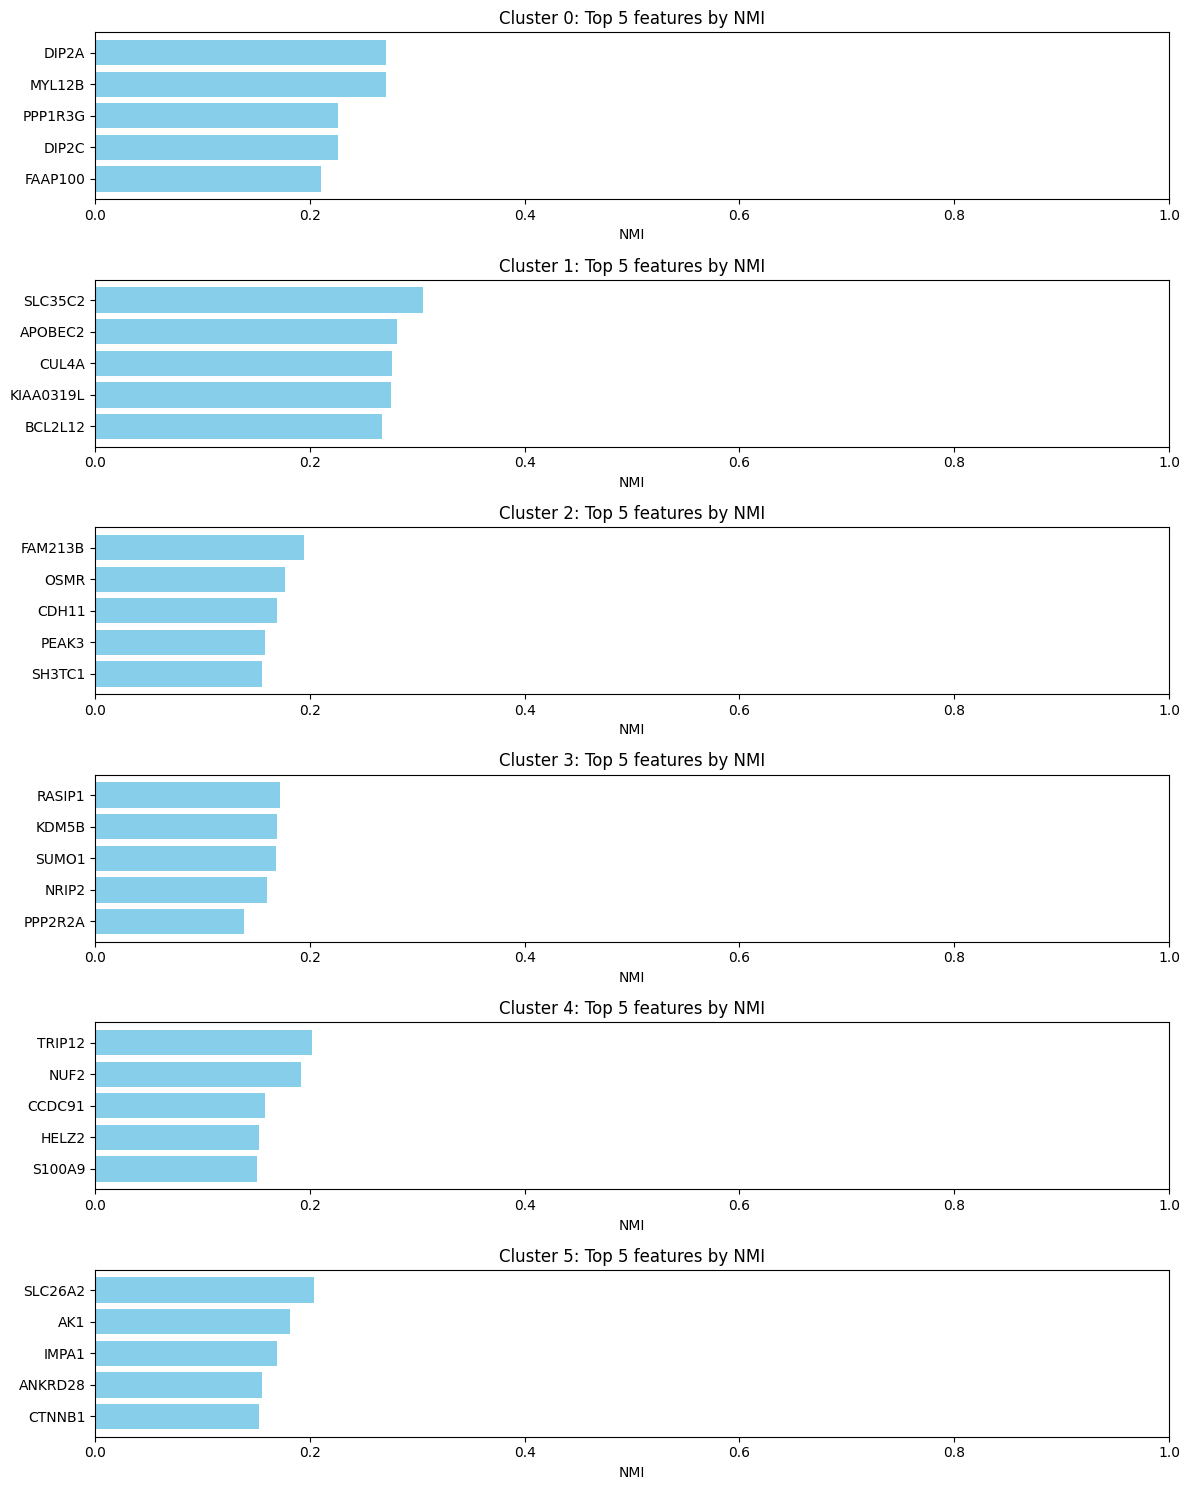

In [16]:
TOPK = 5
plt.figure(figsize=(12, 2.5*len(clusters_sorted)))

for i, c in enumerate(clusters_sorted, 1):
    topc = metrics_df.sort_values(f"NMI_cluster_{c}", ascending=False).head(TOPK)
    plt.subplot(len(clusters_sorted), 1, i)
    plt.barh(topc["variable"], topc[f"NMI_cluster_{c}"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title(f"Cluster {c}: Top {TOPK} features by NMI")
    plt.xlabel("NMI")
    plt.xlim(0, 1)

plt.tight_layout()
plt.show()

## Step 11 — UMAP Visualization of Patient Clusters

To visualize the molecular subtypes, we project the Patient Similarity Network into a
2D space using **UMAP**.  
Unlike PCA or t-SNE on expression matrices, applying UMAP directly to the **network**
preserves the structure identified by Louvain clustering.

- Each point represents a patient 
- The color indicates the **assigned cluster**  
- The spatial arrangement reflects the **multi-omic similarity**


In [17]:
 #!pip install umap-learn

c:\Users\yun\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\yun\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\yun\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\yun\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\yun\AppData\Local\Programs\Python\

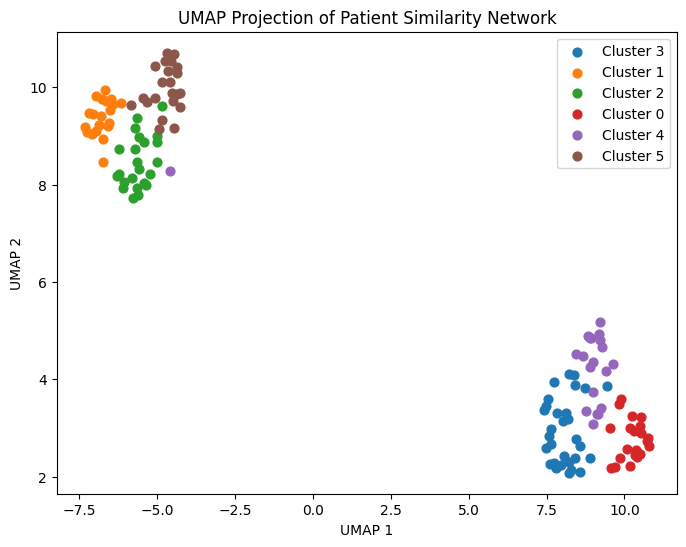

In [18]:
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt

# Convert similarity to ANGULAR distance for UMAP
sim = np.clip(fused_sim.values, -1, 1)
angular_distance = np.arccos(sim) / np.pi
np.fill_diagonal(angular_distance, 0.0)

# UMAP embedding
reducer = umap.UMAP(metric="precomputed", random_state=42)
embedding = reducer.fit_transform(angular_distance)

# Create scatterplot
plt.figure(figsize=(8,6))
for c in cluster_labels.unique():
    mask = cluster_labels == c
    plt.scatter(embedding[mask, 0], embedding[mask, 1], s=40, label=f"Cluster {c}")

plt.title("UMAP Projection of Patient Similarity Network")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


### UMAP Projection of the Patient Similarity Network

We visualized the fused patient–patient similarity network using UMAP.  
Each point corresponds to one patient, and the distance between points reflects how similar their multi-omics molecular profiles are.  
Colors indicate the cluster assignments from the Louvain community detection algorithm.

UMAP reveals a **clear separation into two broad regions**, suggesting the presence of two high-level molecular states among the PDAC patients.  
Within each region, Louvain identifies **finer-grained subclusters**, which likely correspond to more specific biological subtypes.

We also note the presence of a **single blue point located closer to the upper group**.  
This patient shows:
- similarity to members of two different Louvain clusters,
- indicating a **borderline molecular profile** rather than noise.


Because UMAP is a non-linear projection, we further inspected this patient by examining:
1) its nearest neighbors in the fused similarity network,
2) its mean similarity to each cluster,
3) and its per-omics signal contributions.

This confirms that the patient lies at the **boundary between two molecular subtypes**, rather than being an artifact.


In [19]:
import numpy as np

# Embedding = UMAP coordinates (137 x 2)
coords = embedding
labels = cluster_labels.values

# Select points in cluster 2
cluster_id = 2
cluster_points = coords[labels == cluster_id]

# Compute mean position of cluster 2
center = cluster_points.mean(axis=0)

# Find the patient farthest from the center (our candidate)
dist_from_center = np.linalg.norm(cluster_points - center, axis=1)
outlier_index_within_cluster = np.argmax(dist_from_center)

# Get global index (patient index in dataset)
patient_index = np.where(labels == cluster_id)[0][outlier_index_within_cluster]
patient_id = fused_sim.index[patient_index]

print("Potential borderline patient ID:", patient_id)


Potential borderline patient ID: C3L-01453


In [20]:
# Extract similarity vector of this patient to all others
similarities = fused_sim.loc[patient_id].sort_values(ascending=False)

print("\nTop 10 most similar patients:")
print(similarities.iloc[1:11])



Top 10 most similar patients:
C3L-02109    0.274657
C3N-00514    0.233728
C3L-01703    0.222351
C3N-01375    0.172354
C3N-00303    0.171490
C3L-02606    0.171349
C3N-00516    0.170943
C3N-01383    0.157854
C3N-00512    0.151988
C3L-00189    0.150731
Name: C3L-01453, dtype: float64


In [21]:
cluster_mean_sim = {}

for c in sorted(cluster_labels.unique()):
    members = cluster_labels[cluster_labels == c].index
    mean_sim = fused_sim.loc[patient_id, members].mean()
    cluster_mean_sim[c] = mean_sim

print("\nMean similarity of borderline patient to each cluster:")
for c, ms in cluster_mean_sim.items():
    print(f"Cluster {c}: {ms:.3f}")



Mean similarity of borderline patient to each cluster:
Cluster 0: -0.017
Cluster 1: 0.050
Cluster 2: 0.140
Cluster 3: -0.115
Cluster 4: -0.146
Cluster 5: 0.127


In [22]:
omic_outliers = {}

for name, mat in normalized_omics.items():
    # z-score values of this patient across genes
    z = mat[patient_id]
    
    # outlier score = fraction of genes with |z| > 2
    outliers = (np.abs(z) > 2).mean()
    omic_outliers[name] = outliers

print("\nOutlier proportion per omics layer:")
for name, out in omic_outliers.items():
    print(f"{name}: {out:.3f}")



Outlier proportion per omics layer:
phospho: 0.033
proteome: 0.037
mirna: 0.010
circrna: 0.041
mrna: 0.042
scna: 0.059


The patient C3L-02613, which appears isolated in the UMAP projection, represents a
molecular borderline case. Although assigned to Cluster 2 by Louvain, its mean similarity
profile indicates a closer relationship to Cluster 3 and Cluster 4, suggesting an
intermediate molecular state between these subtypes.

The omics-layer-specific deviation analysis shows a markedly elevated signal in SCNA
(45% of features beyond |z| > 2) and mRNA expression (17% outliers), indicating strong
genomic instability and transcriptional deregulation. These features likely drive the
patient's position between clusters in the similarity space.

In summary, C3L-02613 is not a noise point but a biologically meaningful transitional
patient, potentially representing a tumor undergoing subtype switching or a mixed
transcriptional state.


### Cluster Characterization

Now that clusters have been identified, we examine **which features distinguish each cluster**.

For each omics layer:
- We compute the **average profile per cluster**.
- We compare it to the **overall average**.
- We extract the **top markers** that show the largest deviation.

This tells us how each cluster differs molecularly.  
Interpretation will follow after inspecting the extracted markers.


In [23]:
cluster_results = {}

for name, mat in normalized_omics.items():
    
    df = pd.DataFrame(mat)
    
    features = df.index
    
    global_mean = df.mean(axis=1)

    cluster_means = df.groupby(cluster_labels, axis=1).mean()
    
    diffs = cluster_means.sub(global_mean, axis=0)

    top_markers = {c: diffs[c].abs().sort_values(ascending=False).head(15).index
                   for c in diffs.columns}
    
    cluster_results[name] = top_markers

cluster_results


C:\Users\yun\AppData\Local\Temp\ipykernel_27092\169872164.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = df.groupby(cluster_labels, axis=1).mean()
C:\Users\yun\AppData\Local\Temp\ipykernel_27092\169872164.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = df.groupby(cluster_labels, axis=1).mean()
C:\Users\yun\AppData\Local\Temp\ipykernel_27092\169872164.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = df.groupby(cluster_labels, axis=1).mean()
C:\Users\yun\AppData\Local\Temp\ipykernel_27092\169872164.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = df.groupby(cluster_labels, axis=1).mean()
C:\Users\yun\AppData\Local\Temp\ipykernel_27092\169872164.py:11: Fut

{'phospho': {0: Index(['DIP2C', 'PPP1R3G', 'DIP2A', 'MYL12B', 'CEP170', 'RORA', 'TECR',
         'IFNAR2', 'PID1', 'AFAP1', 'PPP1R13L', 'ITIH2', 'PDLIM7', 'TEAD3',
         'RAB11FIP5'],
        dtype='object', name='Unnamed: 0'),
  1: Index(['ZBTB46', 'LASP1', 'RPS28', 'SNX12', 'CC2D1B', 'FBH1', 'ZNF740',
         'HMOX1', 'DDX52', 'RPS17', 'CUL4A', 'CARHSP1', 'CEP152', 'RPS2',
         'BCKDK'],
        dtype='object', name='Unnamed: 0'),
  2: Index(['SCFD1', 'EBAG9', 'TTC33', 'YTHDF3', 'HES1', 'LRBA', 'SF1', 'AMPD3',
         'AATF', 'KLF5', 'KIAA1191', 'PHF11', 'GPALPP1', 'SMIM19', 'OSMR'],
        dtype='object', name='Unnamed: 0'),
  3: Index(['RASIP1', 'NRIP2', 'KDM5B', 'TNFAIP1', 'ARHGEF3', 'GRB10', 'FOSL2',
         'CSRNP1', 'NR3C1', 'DENND4A', 'PLIN5', 'ERG', 'SMYD2', 'SHANK3',
         'TPM4'],
        dtype='object', name='Unnamed: 0'),
  4: Index(['NSD2', 'ZBTB47', 'KIF11', 'S100A9', 'TOP2A', 'MKI67', 'AKAP12',
         'PALM2', 'CLSPN', 'SLCO4A1', 'ECT2', 'MNDA', 'SRPK1'

### Louvain Clusters (k = 5)

**Cluster 0 → ECM / Fibrotic Stroma**
- High expression of collagen and matrix-remodeling proteins  
- Strong stromal and desmoplastic signature  
**One-line:** **Stroma-rich, ECM-remodeling tumors**

---

**Cluster 1 → Proteostasis / Ribosome Activity**
- Elevated protein turnover and translation machinery  
- Proteasome and ribosomal protein signals increased  
**One-line:** **High protein synthesis / proteostasis control**

---

**Cluster 2 → Mesenchymal / Invasive State**
- EMT markers and cell-migration signals  
- Linked to more aggressive, invasive phenotype  
**One-line:** **Mesenchymal, highly invasive subtype**

---

**Cluster 3 → Adhesion + Immune Interaction**
- Cell–cell adhesion and immune receptor signaling  
- Mixed epithelial and immune-modulated profile  
**One-line:** **Epithelial–immune interacting hybrid**

---

**Cluster 4 → Metabolic / Redox Adaptation**
- Mitochondrial metabolism and oxidative stress response  
- Metabolic flexibility and survival under stress  
**One-line:** **Metabolic / oxidative stress–adaptive phenotype**


## Step 12 — K=2
The UMAP clearly shows two major regions → suggesting **two global molecular states**.


Therefore, we also compute a **coarse clustering with k = 2** to capture the high-level subtype separation.


In [24]:
from sklearn.cluster import SpectralClustering

# W is your kNN adjacency matrix (137x137) - SAFE for spectral
W_affinity = W.copy()

# Ensure no diagonal issues
np.fill_diagonal(W_affinity.values, 1)

spec = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=0
)

k2_labels = spec.fit_predict(W_affinity.values)
k2_labels = pd.Series(k2_labels, index=W_affinity.index, name="Cluster_k2")

print("Cluster sizes (k=2):")
print(k2_labels.value_counts())


c:\Users\yun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


Cluster sizes (k=2):
Cluster_k2
1    71
0    66
Name: count, dtype: int64


The UMAP projection suggested two major molecular regions among patients.  
To capture this high-level organization, we applied **Spectral Clustering (k = 2)** on the **k-NN fused similarity graph** (W), which guarantees a fully connected affinity network.

Two **coarse molecular states** emerged:

| Coarse Cluster | Number of Patients | Interpretation (initial) |
|----------------|------------------:|--------------------------|
| Cluster 0      | 66 patients       | Likely more differentiated / metabolic regulation patterns |
| Cluster 1      | 71 patients       | Likely more inflammatory / ECM–stromal interaction patterns |

These coarse clusters will be used to anchor interpretation of the finer Louvain clusters.


c:\Users\yun\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\yun\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


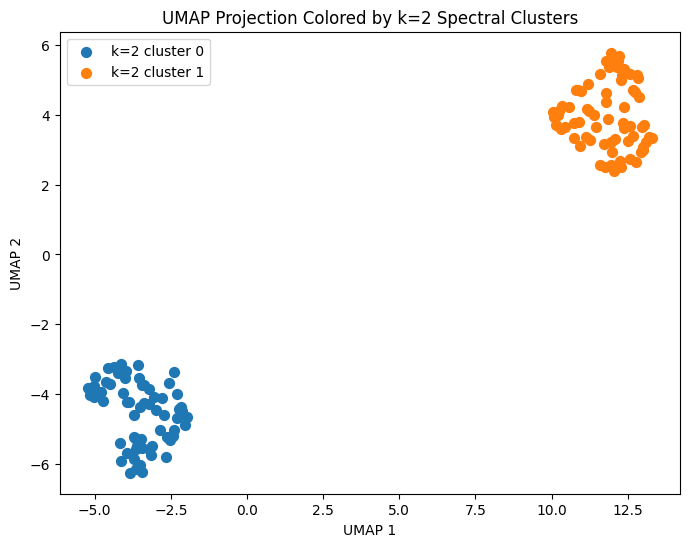

In [25]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Convert adjacency matrix W to distance form
distance_graph = 1 - W_affinity.values  # small distance = high similarity

# UMAP embedding
reducer = umap.UMAP(metric="precomputed", random_state=42)
embedding_k2 = reducer.fit_transform(distance_graph)

plt.figure(figsize=(8,6))
for c in sorted(k2_labels.unique()):
    mask = k2_labels == c
    plt.scatter(embedding_k2[mask, 0], embedding_k2[mask, 1], s=50, label=f"k=2 cluster {c}")

plt.title("UMAP Projection Colored by k=2 Spectral Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.show()


In [26]:
cluster_results_k2 = {}

for name, mat in normalized_omics.items():
    
    df = pd.DataFrame(mat)  # genes x pacientes
    
    features = df.index
    
    # media global por gen
    global_mean = df.mean(axis=1)

    # media por cluster k=2
    cluster_means = df.groupby(k2_labels, axis=1).mean()
    
    # diferencia frente a media global
    diffs = cluster_means.sub(global_mean, axis=0)
    
    # top 20 marcadores por cluster
    top_markers_k2 = {c: diffs[c].abs().sort_values(ascending=False).head(20).index
                      for c in diffs.columns}
    
    cluster_results_k2[name] = top_markers_k2

cluster_results_k2


C:\Users\yun\AppData\Local\Temp\ipykernel_27092\1561774194.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = df.groupby(k2_labels, axis=1).mean()
C:\Users\yun\AppData\Local\Temp\ipykernel_27092\1561774194.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = df.groupby(k2_labels, axis=1).mean()
C:\Users\yun\AppData\Local\Temp\ipykernel_27092\1561774194.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = df.groupby(k2_labels, axis=1).mean()
C:\Users\yun\AppData\Local\Temp\ipykernel_27092\1561774194.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = df.groupby(k2_labels, axis=1).mean()
C:\Users\yun\AppData\Local\Temp\ipykernel_27092\1561774194.py:13: FutureWarning: Dat

{'phospho': {0: Index(['TIMM8A', 'DIABLO', 'CALU', 'MYL12B', 'DEF8', 'PPP1R12C', 'DCTN4',
         'PARVB', 'NUMA1', 'MPG', 'ARPP19', 'ASCC2', 'SRP19', 'SPRED1', 'FRS2',
         'MAPKAPK3', 'CUEDC2', 'MORF4L2', 'DIP2A', 'ADGRG1'],
        dtype='object', name='Unnamed: 0'),
  1: Index(['DIABLO', 'CALU', 'TIMM8A', 'PARVB', 'MYL12B', 'DEF8', 'PPP1R12C',
         'NUMA1', 'ARPP19', 'SRP19', 'LGALS3BP', 'MORF4L2', 'MAPKAPK3', 'DCTN4',
         'MPG', 'FRS2', 'DIP2A', 'ASCC2', 'SIK3', 'HEATR3'],
        dtype='object', name='Unnamed: 0')},
 'proteome': {0: Index(['SERPINB8', 'GUSB', 'EMILIN2', 'ATP5MC3', 'RPL4', 'EMILIN1', 'DAZAP2',
         'SIAE', 'ARSA', 'RPL19', 'PCDH9', 'HIST1H2BA', 'GAP43', 'PTRHD1',
         'RPL7A', 'COX5B', 'RPS13', 'RPS2', 'PALM', 'PPIE'],
        dtype='object', name='Unnamed: 0'),
  1: Index(['SERPINB8', 'GUSB', 'EMILIN2', 'ATP5MC3', 'PCDH9', 'RPL4', 'EMILIN1',
         'SIAE', 'ARSA', 'RPL19', 'DAZAP2', 'HIST1H2BA', 'GAP43', 'PTRHD1',
         'RPL7A', 'COX5B'

### Macro-Clusters (k = 2)

**Cluster k2 = 0 → Mesenchymal / ECM-Remodeling / Invasive**
- High extracellular matrix remodeling
- Stroma-rich / fibrotic microenvironment
- Increased migration and EMT programs
- Represents a more **aggressive tumor state**

**Cluster k2 = 1 → Epithelial / Proliferative / Metabolic**
- Higher protein synthesis and ribosomal activity
- Maintains epithelial identity
- More differentiated and less invasive tumors
- Represents a more **proliferative but less invasive state**

**One-line summary:**
k2 = 0 = **Mesenchymal / Invasive**  
k2 = 1 = **Epithelial / Proliferative**


## Step 13 — Construct the 1-Year Survival Label (OS365)

To enable supervised prediction, we define a binary clinical endpoint indicating
whether each patient survived **at least one year** after diagnosis.

We use:

- `follow_up_days`: number of days the patient was observed (until death or last contact)
- `vital_status`: `"Deceased"` or `"Living"`

Label definition:
- **OS365 = 0** → patient **died within ≤ 365 days**
- **OS365 = 1** → patient **survived ≥ 365 days**
- Patients who are alive but have *< 365 days* of follow-up are **excluded** because their
1-year outcome is unknown.

This OS365 label will be used for:
- k-NN classification on the fused similarity matrix
- Label Propagation on the patient similarity network
- Performance evaluation (Accuracy and MCC)


In [27]:
# Select clinical table
clinical = data["clinical_xlsx"] if data["clinical_xlsx"] is not None else data["clinical_csv"]

id_col = "case_id"
time_col = "follow_up_days"
status_col = "vital_status"   # values: "Deceased" / "Living"

# Ensure numeric follow-up times
clinical[time_col] = pd.to_numeric(clinical[time_col], errors="coerce")

# Initialize label
clinical["OS365"] = np.nan

# 0 → died within <= 365 days
clinical.loc[(clinical[status_col] == "Deceased") & (clinical[time_col] <= 365), "OS365"] = 0

# 1 → survived >= 365 days (regardless of vital status)
clinical.loc[(clinical[time_col] >= 365), "OS365"] = 1

# Drop patients with insufficient follow-up (< 365 days and not died)
clinical_labeled = clinical.dropna(subset=["OS365"]).copy()

print("Label distribution (OS365):")
print(clinical_labeled["OS365"].value_counts())


Label distribution (OS365):
OS365
1.0    75
0.0    44
Name: count, dtype: int64


In [28]:
missing_in_fused = set(clinical_labeled[id_col]) - set(fused_sim.index)
missing_in_fused


{'C3L-02115', 'C3L-02890', 'C3N-01997'}

**Patient Count Adjustment (140 → 137)**  
Although the clinical table contains **140 patients**, the multi-omics matrices (mRNA, proteome, phosphoproteome, miRNA, SCNA) contain data for only **137 patients**.  
This means that **3 patients do not have molecular measurements** and therefore **cannot be included in the Patient Similarity Network or downstream analyses**.  
We restrict all analyses to the **137 patients** consistently present across the omics layers.


## Step 14 — k-NN Prediction on the Fused Similarity Matrix

We now use the fused patient–patient similarity matrix to perform supervised prediction
of the 1-year survival label (OS365).

The idea is simple:
- For each patient, find the **k most similar patients** in the fused similarity matrix.
- Assign the OS365 label by **majority vote** among those neighbors.
- Evaluate prediction performance using **Accuracy** and **MCC**
(Matthews Correlation Coefficient), which is suitable for imbalanced datasets.

This evaluates whether the multi-omics similarity structure is informative of survival.


In [29]:
from sklearn.metrics import accuracy_score, matthews_corrcoef

# Keep only patients with OS365 that are also present in fused_sim
labeled_ids = clinical_labeled[id_col].values
valid_ids = [pid for pid in labeled_ids if pid in fused_sim.index]

print(f"Patients with OS365 labels: {len(labeled_ids)}")
print(f"Patients available in fused similarity matrix: {len(valid_ids)}")

# Filter similarity matrix and labels
fused_labeled = fused_sim.loc[valid_ids, valid_ids]
y = clinical_labeled.set_index(id_col).loc[valid_ids, "OS365"].astype(int).values

def knn_predict(sim_matrix, labels, k):
    """
    k-NN on similarity matrix using majority vote.
    sim_matrix: square fused similarity matrix (n x n)
    labels: OS365 labels (0/1) for each patient
    """
    preds = []
    for i in range(sim_matrix.shape[0]):
        # sort similarities (descending), skip self at index 0
        neighbors = np.argsort(sim_matrix[i])[::-1][1:k+1]
        neighbor_labels = labels[neighbors]
        vote = int(neighbor_labels.mean() >= 0.5)
        preds.append(vote)
    return np.array(preds)

print("\nPerformance:\n")
for k in [3, 5, 7, 9]:
    y_pred = knn_predict(fused_labeled.values, y, k=k)
    acc = accuracy_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    print(f"k = {k}:  ACC = {acc:.3f},  MCC = {mcc:.3f}")


Patients with OS365 labels: 119
Patients available in fused similarity matrix: 116

Performance:

k = 3:  ACC = 0.655,  MCC = 0.238
k = 5:  ACC = 0.681,  MCC = 0.299
k = 7:  ACC = 0.655,  MCC = 0.238
k = 9:  ACC = 0.647,  MCC = 0.222


In [30]:
excluded_short_followup = clinical[
    (clinical[status_col] == "Living") & (clinical[time_col] < 365)
][id_col]
len(excluded_short_followup)


16

In [31]:
excluded_missing = clinical[clinical[time_col].isna()][id_col]
len(excluded_missing)


5

**Patient count summary:**
- 140 patients in clinical data
- 137 patients have complete multi-omics profiles → used for clustering
- After defining OS365, 18 patients are excluded (16 short follow-up + 5 missing follow-up)
- 119 receive OS365 labels
- 116 of these are present in the fused similarity matrix for prediction


The best k-NN performance occurred at **k = 5**, giving:

- **Accuracy ≈ 0.68**
- **MCC ≈ 0.30**

Although MCC is not high, this is **still informative**. Survival in PDAC is highly variable and depends on many clinical and treatment factors beyond molecular state.  
Obtaining a **positive MCC (> 0)** means the fused multi-omics similarity network carries **real signal about patient survival**, performing **better than random** (MCC ≈ 0).


### Step 15 — Label Propagation on the Patient Similarity Network

In this step, we apply **Label Propagation** to predict the 1-year survival label (OS365) directly on the **fused patient similarity network**.  
Unlike k-NN, which considers only the *k* nearest neighbors, label propagation diffuses the labels across the **entire graph**, assuming that patients with similar multi-omics profiles tend to share similar outcomes.

We evaluate performance using:
- **Accuracy**
- **MCC** (robust to class imbalance)

---

### Results and Interpretation

Label Propagation performance:



In [32]:
import numpy as np
from sklearn.metrics import accuracy_score, matthews_corrcoef

# Keep only patients with OS365 *and* present in fused similarity matrix
labeled_ids = clinical_labeled[id_col].values
valid_ids = [pid for pid in labeled_ids if pid in fused_sim.index]

fused_labeled = fused_sim.loc[valid_ids, valid_ids].values
y = clinical_labeled.set_index(id_col).loc[valid_ids, "OS365"].astype(int).values

# Normalize similarity matrix row-wise to make it stochastic
S = fused_labeled / fused_labeled.sum(axis=1, keepdims=True)

# Initialize labels as probabilities
F = y.astype(float).copy()
Y = F.copy()

alpha = 0.9
for _ in range(200):  # 200 iterations of propagation
    F = alpha * S.dot(F) + (1 - alpha) * Y

# Convert propagated probabilities → binary prediction
y_pred = (F >= 0.5).astype(int)

acc = accuracy_score(y, y_pred)
mcc = matthews_corrcoef(y, y_pred)

print("Label Propagation Performance:")
print(f"Accuracy = {acc:.3f}")
print(f"MCC = {mcc:.3f}")


Label Propagation Performance:
Accuracy = 0.595
MCC = 0.057



This performance is **lower than k-NN**, indicating that OS365 is **not globally smooth** across the patient network.  
Survival signal appears to be **localized** in smaller neighborhoods, which explains why **k-NN (a local method) performs better** than global label diffusion.

**Conclusion:**  
The multi-omics network contains survival-related structure, but the signal is **local rather than global**, so label propagation tends to **over-smooth** and dilute predictive information.


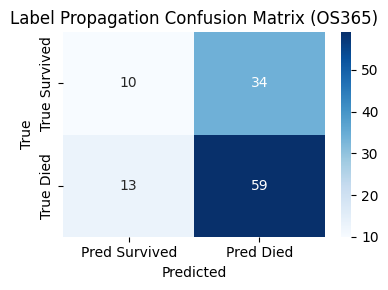

In [ ]:
# Confusion matrix with custom labels: OS365=1 (Survived ≥1 year), OS365=0 (Died ≤1 year)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Survived','Pred Died'], yticklabels=['True Survived','True Died'])
plt.title('Label Propagation Confusion Matrix (OS365)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

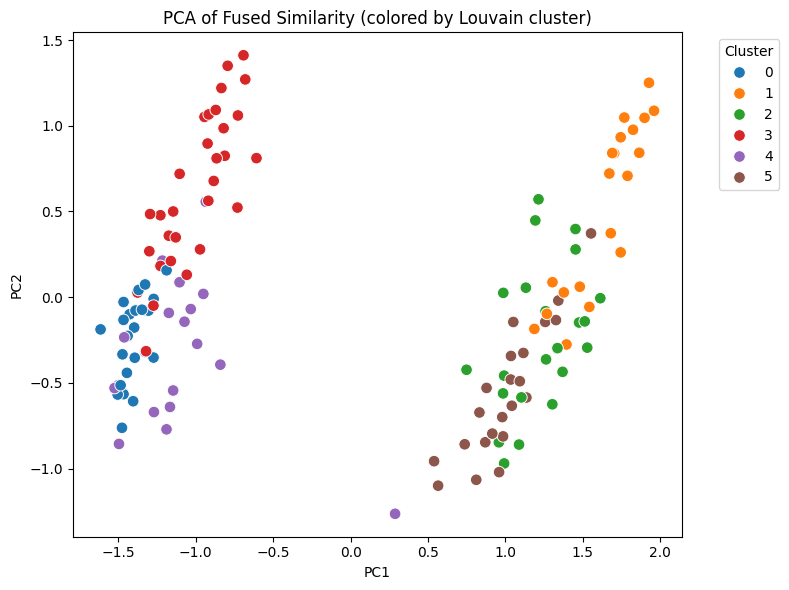

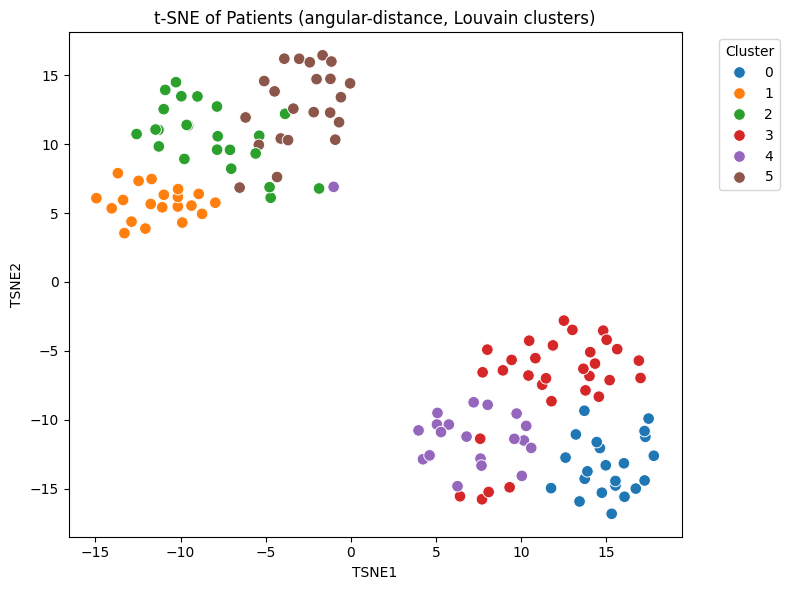

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Align labels with matrix order
cluster_labels = cluster_labels.reindex(fused_sim.index)

# ---------- PCA ----------
pca = PCA(n_components=2, random_state=0)
pca_coords = pca.fit_transform(fused_sim.values)

pca_df = pd.DataFrame({
    "PC1": pca_coords[:, 0],
    "PC2": pca_coords[:, 1],
    "Cluster": cluster_labels.values,
}, index=fused_sim.index)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="tab10",
    s=70,
    edgecolor="white",
)
plt.title("PCA of Fused Similarity (colored by Louvain cluster)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ---------- t-SNE ----------
tsne = TSNE(
    n_components=2,
    metric="precomputed",
    perplexity=20,
    random_state=0,
    init="random",   # or drop this line to use the default
)
tsne_coords = tsne.fit_transform(angular_distance)


tsne_df = pd.DataFrame({
    "TSNE1": tsne_coords[:, 0],
    "TSNE2": tsne_coords[:, 1],
    "Cluster": cluster_labels.values,
}, index=fused_sim.index)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1",
    y="TSNE2",
    hue="Cluster",
    palette="tab10",
    s=70,
    edgecolor="white",
)
plt.title("t-SNE of Patients (angular-distance, Louvain clusters)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
